In [109]:
import pandas as pd
import quandl
import math
import pickle #used to save classifier

df = quandl.get('WIKI/GOOGL')
df = df[['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume']]
# High to low percentage
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Low']) / df['Adj. Low'] * 100.0
# Daily percentage
df['Change_PCT'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100.0
# Redefine data we need (features)
df = df[['Adj. Close', 'HL_PCT', 'Change_PCT', 'Adj. Volume']]

print(df.head())

            Adj. Close    HL_PCT  Change_PCT  Adj. Volume
Date                                                     
2004-08-19   50.322842  8.441017    0.324968   44659000.0
2004-08-20   54.322689  8.537313    7.227007   22834300.0
2004-08-23   54.869377  4.062357   -1.227880   18256100.0
2004-08-24   52.597363  7.753210   -5.726357   15247300.0
2004-08-25   53.164113  3.966115    1.183658    9188600.0


In [110]:
forecast_col = 'Adj. Close'
df.fillna(-99999, inplace=True)

import math
# predict 1% of data
forecast_out = math.ceil(0.01 * len(df))

print(df.head())


print(forecast_out)

            Adj. Close    HL_PCT  Change_PCT  Adj. Volume
Date                                                     
2004-08-19   50.322842  8.441017    0.324968   44659000.0
2004-08-20   54.322689  8.537313    7.227007   22834300.0
2004-08-23   54.869377  4.062357   -1.227880   18256100.0
2004-08-24   52.597363  7.753210   -5.726357   15247300.0
2004-08-25   53.164113  3.966115    1.183658    9188600.0
35


In [118]:
df['label'] = df[forecast_col].shift(-forecast_out)
print(df.head())

            Adj. Close    HL_PCT  Change_PCT  Adj. Volume      label
Date                                                                
2004-08-19   50.322842  8.441017    0.324968   44659000.0  69.078238
2004-08-20   54.322689  8.537313    7.227007   22834300.0  67.839414
2004-08-23   54.869377  4.062357   -1.227880   18256100.0  68.912727
2004-08-24   52.597363  7.753210   -5.726357   15247300.0  70.668146
2004-08-25   53.164113  3.966115    1.183658    9188600.0  71.219849


In [119]:
# machine learning part
import numpy as np
from sklearn import preprocessing, svm #used to split data and ransomize (cross_validation)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# define features (everything except for label)
X = np.array(df.drop(['label', "Adj. Close"], 1))

# scale
X = preprocessing.scale(X)
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

# X = X[:-forecast_out]
df.dropna(inplace=True)
y = np.array(df['label'])

print(len(X), len(y))

3354 3354


In [120]:
# get training and testing set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [121]:
# define classifier

clf = LinearRegression()

clf.fit(X_train, y_train)
# save classifier
with open('./trained_models/stock_linear_regression', 'wb') as f:
    pickle.dump(clf, f)

In [124]:
pickle_in = open('./trained_models/stock_linear_regression', 'rb')
clf = pickle.load(pickle_in)

In [125]:
accuracy = clf.score(X_test, y_test)
print(accuracy)

0.3253914388544573


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1E5533F0>,
      dtype=object)

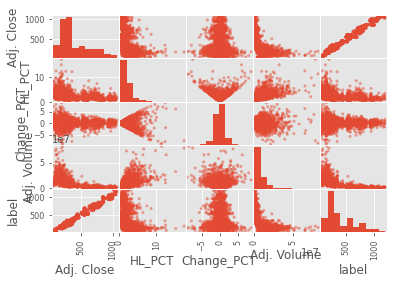

In [126]:
pd.plotting.scatter_matrix(df)

In [127]:
forecast_set = clf.predict(X_lately)

print(forecast_set, accuracy, forecast_out)

[510.95902608 484.76492184 509.91863029 515.94394312 514.26020141
 518.92205608 525.73194423 522.73528477 521.55197017 521.64341761
 520.63725823 504.3884075  505.15799009 516.82536995 511.78745848
 518.75794845 516.53367968 520.81374515 520.25806931 499.07865452
 505.62945611 513.20299281 514.19706862 513.48486945 506.41480078
 507.0176893  506.71062353 513.80584786 502.45599913 511.79581874
 507.66413374 509.90472513 489.60506667 442.03037945 463.01733174] 0.3253914388544573 35


In [128]:
import matplotlib.pyplot as plt
from matplotlib import style
import datetime

style.use('ggplot')


df['Forecast'] = np.nan

last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix+ one_day

for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns) - 1)] + [i]


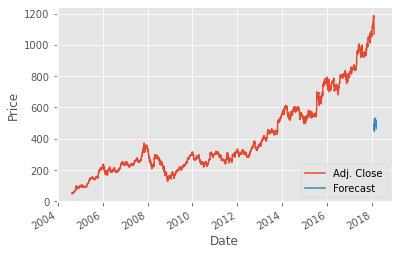

In [95]:
df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()